In [20]:
# importing library
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

In [21]:
# reading dataset
df = pd.read_csv(r'C:\Users\akank\Dropbox\My PC (LAPTOP-NQ9H8NTJ)\Documents\Sem 8\Project\datasets\brown\brown.csv')

df

,filename,para_id,sent_id,raw_text,tokenized_text,tokenized_pos,label
0,cd05,0,0,"Furthermore/rb ,/, as/cs an/at encouragement/n...","Furthermore , as an encouragement to revisioni...","rb , cs at nn in nn nn , pps rb bez jj to vb c...",religion
1,cd05,0,1,The/at Unitarian/jj clergy/nns were/bed an/at ...,The Unitarian clergy were an exclusive club of...,at jj nns bed at jj nn in vbn nns -- cs at nn ...,religion
2,cd05,0,2,"Ezra/np Stiles/np Gannett/np ,/, an/at honorab...","Ezra Stiles Gannett , an honorable representat...","np np np , at jj nn in at nn , vbd ppl rb in a...",religion
3,cd05,0,3,"Even/rb so/rb ,/, Gannett/np judiciously/rb ar...","Even so , Gannett judiciously argued , the Ass...","rb rb , np rb vbd , at nn-tl md rb vb cs np ``...",religion
4,cd05,0,4,We/ppss today/nr are/ber not/* entitled/vbn to...,We today are not entitled to excoriate honest ...,ppss nr ber * vbn to vb jj nns wps vbd np to b...,religion
...,...,...,...,...,...,...,...
57335,cj14,6,3,"For/in the/at most/ap part/nn ,/, this/dt disc...","For the most part , this discussion will be co...","in at ap nn , dt nn md be vbn in nns vbn in at...",learned
57336,cj14,6,4,A/np-hl ./.-hl,A .,np-hl .-hl,learned
57337,cj14,6,5,Standard/jj-hl preparations/nns-hl and/cc-hl u...,Standard preparations and units of thyroid-sti...,jj-hl nns-hl cc-hl nns-hl in-hl jj-hl nn-hl,learned
57338,cj14,6,6,The/at international/jj unit/nn (/( u./nn )/) ...,"The international unit ( u. ) , adopted to mak...","at jj nn ( nn ) , vbn to vb jj at nn in nns in...",learned


# 1. Data Preparation

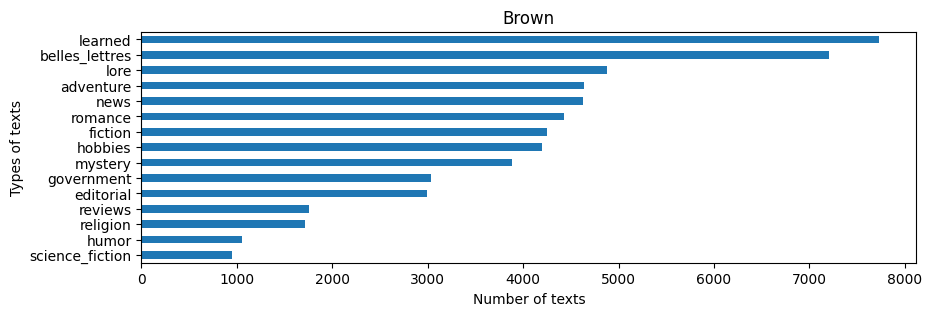

In [22]:
plt.figure(figsize=(10, 3))
df.groupby([df['label']]).size().sort_values(ascending=True).plot(kind='barh')
plt.title('Brown')
plt.xlabel('Number of texts')
plt.ylabel('Types of texts')
plt.show()

In [23]:
# dropping labels other than defined Fiction and Non-Fiction labels

index = df[(df.label == 'religion') | (df.label == 'lore') | (df.label == 'editorial') | 
(df.label == 'humor') | (df.label == 'belles_lettres')].index

df.drop(index, inplace = True)

df

,filename,para_id,sent_id,raw_text,tokenized_text,tokenized_pos,label
164,cj50,0,0,"Unfortunately/rb ,/, however/rb ,/, and/cc for...","Unfortunately , however , and for reasons to b...","rb , rb , cc in nns to be vbn in at vbg nn , a...",learned
165,cj50,0,1,And/cc this/dt fact/nn may/md explain/vb some/...,And this fact may explain some of the disagree...,cc dt nn md vb dti in at nns in at nns in in a...,learned
166,cj50,0,2,"One/cd such/jj disagreement/nn ,/, which/wdt w...","One such disagreement , which will receive att...","cd jj nn , wdt md vb nn in dt ap nn , vbz at n...",learned
167,cj50,0,3,"Here/rb ,/, the/at choice/nn is/bez that/dt be...","Here , the choice is that between the horns of...","rb , at nn bez dt in at nns in at nn .",learned
168,cj50,1,0,Two/cd-hl major/jj-hl types/nns-hl of/in-hl fu...,Two major types of fully distributed cost anal...,cd-hl jj-hl nns-hl in-hl rb-hl vbn-hl nn-hl nn-hl,learned
...,...,...,...,...,...,...,...
57335,cj14,6,3,"For/in the/at most/ap part/nn ,/, this/dt disc...","For the most part , this discussion will be co...","in at ap nn , dt nn md be vbn in nns vbn in at...",learned
57336,cj14,6,4,A/np-hl ./.-hl,A .,np-hl .-hl,learned
57337,cj14,6,5,Standard/jj-hl preparations/nns-hl and/cc-hl u...,Standard preparations and units of thyroid-sti...,jj-hl nns-hl cc-hl nns-hl in-hl jj-hl nn-hl,learned
57338,cj14,6,6,The/at international/jj unit/nn (/( u./nn )/) ...,"The international unit ( u. ) , adopted to mak...","at jj nn ( nn ) , vbn to vb jj at nn in nns in...",learned


In [24]:
# changing labels to fiction_genre and non_fiction_genre

df["label"] = np.where(df["label"] == ('fiction' or 'mystery' or 'romance' or 'adventure' or 'science_fiction'), 
                                        "fiction_genre", "non_fiction_genre")
                                        
df

,filename,para_id,sent_id,raw_text,tokenized_text,tokenized_pos,label
164,cj50,0,0,"Unfortunately/rb ,/, however/rb ,/, and/cc for...","Unfortunately , however , and for reasons to b...","rb , rb , cc in nns to be vbn in at vbg nn , a...",non_fiction_genre
165,cj50,0,1,And/cc this/dt fact/nn may/md explain/vb some/...,And this fact may explain some of the disagree...,cc dt nn md vb dti in at nns in at nns in in a...,non_fiction_genre
166,cj50,0,2,"One/cd such/jj disagreement/nn ,/, which/wdt w...","One such disagreement , which will receive att...","cd jj nn , wdt md vb nn in dt ap nn , vbz at n...",non_fiction_genre
167,cj50,0,3,"Here/rb ,/, the/at choice/nn is/bez that/dt be...","Here , the choice is that between the horns of...","rb , at nn bez dt in at nns in at nn .",non_fiction_genre
168,cj50,1,0,Two/cd-hl major/jj-hl types/nns-hl of/in-hl fu...,Two major types of fully distributed cost anal...,cd-hl jj-hl nns-hl in-hl rb-hl vbn-hl nn-hl nn-hl,non_fiction_genre
...,...,...,...,...,...,...,...
57335,cj14,6,3,"For/in the/at most/ap part/nn ,/, this/dt disc...","For the most part , this discussion will be co...","in at ap nn , dt nn md be vbn in nns vbn in at...",non_fiction_genre
57336,cj14,6,4,A/np-hl ./.-hl,A .,np-hl .-hl,non_fiction_genre
57337,cj14,6,5,Standard/jj-hl preparations/nns-hl and/cc-hl u...,Standard preparations and units of thyroid-sti...,jj-hl nns-hl cc-hl nns-hl in-hl jj-hl nn-hl,non_fiction_genre
57338,cj14,6,6,The/at international/jj unit/nn (/( u./nn )/) ...,"The international unit ( u. ) , adopted to mak...","at jj nn ( nn ) , vbn to vb jj at nn in nns in...",non_fiction_genre


In [25]:
# dropping paragraphs with sentences less than 5 or 6 (to deal with data imbalance)

sent_count = df.groupby(['filename', 'para_id'], as_index =  False).size()
print(sent_count)

for i in range(len(sent_count)):
    size = sent_count['size'].iloc[i]
    if((size<5) or (size>6)):
        doc = sent_count['filename'].iloc[i]
        para = sent_count['para_id'].iloc[i]
        index = df[(df['filename'] == doc) & (df['para_id'] == para)].index
        df.drop(index, inplace = True)
        
df

      filename  para_id  size
0         ca01        0     1
1         ca01        1     1
2         ca01        2     1
3         ca01        3     1
4         ca01        4     1
...        ...      ...   ...
11428     cp29       31     3
11429     cp29       32     1
11430     cp29       33     3
11431     cp29       34     3
11432     cp29       35     1

[11433 rows x 3 columns]


,filename,para_id,sent_id,raw_text,tokenized_text,tokenized_pos,label
168,cj50,1,0,Two/cd-hl major/jj-hl types/nns-hl of/in-hl fu...,Two major types of fully distributed cost anal...,cd-hl jj-hl nns-hl in-hl rb-hl vbn-hl nn-hl nn-hl,non_fiction_genre
169,cj50,1,1,1/cd-hl ./.-hl,1 .,cd-hl .-hl,non_fiction_genre
170,cj50,1,2,The/at-hl double-step/nn-hl type/nn-hl,The double-step type,at-hl nn-hl nn-hl,non_fiction_genre
171,cj50,1,3,Despite/in an/at ambiguity/nn due/jj to/in its...,Despite an ambiguity due to its failure clearl...,"in at nn jj in pp$ nn rb to vb `` jj nns '' , ...",non_fiction_genre
172,cj50,1,4,"For/in more/ql explicit/jj expositions/nns ,/,...","For more explicit expositions , one must disti...","in ql jj nns , pn md vb jj nns in nns .",non_fiction_genre
...,...,...,...,...,...,...,...
57327,cj14,5,1,"First/rb ,/, is/bez the/at circulating/vbg for...","First , is the circulating form of the hormone...","rb , bez at vbg nn in at nn at ap cs dt vbn in...",non_fiction_genre
57328,cj14,5,2,"Second/rb ,/, what/wdt is/bez its/pp$ concentr...","Second , what is its concentration in normal c...","rb , wdt bez pp$ nn in jj nns cc in wdt nns md...",non_fiction_genre
57329,cj14,5,3,It/pps is/bez therefore/rb necessary/jj to/to ...,It is therefore necessary to consider the prop...,pps bez rb jj to vb at nns in jj nn cs at jj n...,non_fiction_genre
57330,cj14,5,4,The/at importance/nn of/in knowing/vbg in/in w...,The importance of knowing in what chemical for...,at nn in vbg in wdt nn nns at nn md vb bez vbn...,non_fiction_genre


In [26]:
# storing labels of each paragraph
df_label = {k: f.groupby('para_id')['label'].apply(list).to_dict()
     for k, f in df.groupby('filename')}

class_label = []
for file_id, filename in df_label.items():
    for para_id, label in filename.items():
            class_label.append(label[0])
            
print(class_label)

pd.DataFrame(class_label, columns= ['label']).to_csv("labels.csv")

['non_fiction_genre', 'non_fiction_genre', 'non_fiction_genre', 'non_fiction_genre', 'non_fiction_genre', 'non_fiction_genre', 'non_fiction_genre', 'non_fiction_genre', 'non_fiction_genre', 'non_fiction_genre', 'non_fiction_genre', 'non_fiction_genre', 'non_fiction_genre', 'non_fiction_genre', 'non_fiction_genre', 'non_fiction_genre', 'non_fiction_genre', 'non_fiction_genre', 'non_fiction_genre', 'non_fiction_genre', 'non_fiction_genre', 'non_fiction_genre', 'non_fiction_genre', 'non_fiction_genre', 'non_fiction_genre', 'non_fiction_genre', 'non_fiction_genre', 'non_fiction_genre', 'non_fiction_genre', 'non_fiction_genre', 'non_fiction_genre', 'non_fiction_genre', 'non_fiction_genre', 'non_fiction_genre', 'non_fiction_genre', 'non_fiction_genre', 'non_fiction_genre', 'non_fiction_genre', 'non_fiction_genre', 'non_fiction_genre', 'non_fiction_genre', 'non_fiction_genre', 'non_fiction_genre', 'non_fiction_genre', 'non_fiction_genre', 'non_fiction_genre', 'non_fiction_genre', 'non_fiction

# 2. Data Pre-Processing

In [27]:
# removing punctuation
import string

def remove_punctuation(text):
    no_punct=[words for words in text if words not in string.punctuation]
    words_wo_punct=''.join(no_punct)
    return words_wo_punct

df['tokenized_text_wo_punct'] =  df['tokenized_text'].apply(lambda x: remove_punctuation(x))

df

,filename,para_id,sent_id,raw_text,tokenized_text,tokenized_pos,label,tokenized_text_wo_punct
168,cj50,1,0,Two/cd-hl major/jj-hl types/nns-hl of/in-hl fu...,Two major types of fully distributed cost anal...,cd-hl jj-hl nns-hl in-hl rb-hl vbn-hl nn-hl nn-hl,non_fiction_genre,Two major types of fully distributed cost anal...
169,cj50,1,1,1/cd-hl ./.-hl,1 .,cd-hl .-hl,non_fiction_genre,1
170,cj50,1,2,The/at-hl double-step/nn-hl type/nn-hl,The double-step type,at-hl nn-hl nn-hl,non_fiction_genre,The doublestep type
171,cj50,1,3,Despite/in an/at ambiguity/nn due/jj to/in its...,Despite an ambiguity due to its failure clearl...,"in at nn jj in pp$ nn rb to vb `` jj nns '' , ...",non_fiction_genre,Despite an ambiguity due to its failure clearl...
172,cj50,1,4,"For/in more/ql explicit/jj expositions/nns ,/,...","For more explicit expositions , one must disti...","in ql jj nns , pn md vb jj nns in nns .",non_fiction_genre,For more explicit expositions one must distin...
...,...,...,...,...,...,...,...,...
57327,cj14,5,1,"First/rb ,/, is/bez the/at circulating/vbg for...","First , is the circulating form of the hormone...","rb , bez at vbg nn in at nn at ap cs dt vbn in...",non_fiction_genre,First is the circulating form of the hormone ...
57328,cj14,5,2,"Second/rb ,/, what/wdt is/bez its/pp$ concentr...","Second , what is its concentration in normal c...","rb , wdt bez pp$ nn in jj nns cc in wdt nns md...",non_fiction_genre,Second what is its concentration in normal ci...
57329,cj14,5,3,It/pps is/bez therefore/rb necessary/jj to/to ...,It is therefore necessary to consider the prop...,pps bez rb jj to vb at nns in jj nn cs at jj n...,non_fiction_genre,It is therefore necessary to consider the prop...
57330,cj14,5,4,The/at importance/nn of/in knowing/vbg in/in w...,The importance of knowing in what chemical for...,at nn in vbg in wdt nn nns at nn md vb bez vbn...,non_fiction_genre,The importance of knowing in what chemical for...


In [28]:
# POS Tagging, Dependency and Constituency Parsing is done before Feature Extraction in next step

# 3. Feature Extraction

In [ ]:
from feature_calculation.feature import Features

# calling Features class from feature_extraction.py
features = Features()

# creating sentence list for each paragraph
df_dict = {k: f.groupby('para_id')['tokenized_text_wo_punct'].apply(list).to_dict()
     for k, f in df.groupby('filename')}

# getting all features for each paragraph
feature_list = []
for file_id, filename in df_dict.items():
    for para_id, sent_list in filename.items():
            feature_list.append(features.get_all_features(sent_list))

# saving the features in a new dataframe
features = pd.DataFrame(feature_list)
features.to_csv("extracted_features.csv")

# 4. Supervised Learning

In [45]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# calling the dataframe which will be used for training
data = pd.read_csv(r'C:\Users\akank\Dropbox\My PC (LAPTOP-NQ9H8NTJ)\Documents\Sem 8\Project\code\extracted_features.csv')
y = pd.read_csv(r'C:\Users\akank\Dropbox\My PC (LAPTOP-NQ9H8NTJ)\Documents\Sem 8\Project\code\labels.csv')
data = data.fillna(0)

# scaling data
scaler = StandardScaler()
X = scaler.fit_transform(data)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1208, 24)
(302, 24)
(1208, 2)
(302, 2)


In [46]:
# defining classifier
clf = LogisticRegression(penalty = 'l1', solver= 'saga', max_iter = 1000)

rfecv = RFECV(
    estimator=clf,
    step=1,
    cv=10, 
    scoring= "accuracy",
    n_jobs=2,
)
rfecv.fit(X_train, y_train.label)
y_pred = rfecv.predict(X_test)
accuracy_score = rfecv.score(X_test, y_test.label)


Testing Accuracy:
 0.9105960264900662

Classification Report:
                    precision    recall  f1-score   support

    fiction_genre       0.00      0.00      0.00        27
non_fiction_genre       0.91      1.00      0.95       275

         accuracy                           0.91       302
        macro avg       0.46      0.50      0.48       302
     weighted avg       0.83      0.91      0.87       302



C:\Users\akank\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\akank\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\akank\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

# 5. Results

In [51]:
# printing results
print('\nTesting Accuracy:\n', accuracy_score)
print('\nClassification Report:\n', classification_report(y_test.label, y_pred))

print(f"Ranking of features (Selected features are given rank 1): {rfecv.ranking_}")
print(data.columns)

optimal_features = []
for i in range(len(data.columns)):
    if((rfecv.ranking_[i])==1):
        optimal_features.append(data.columns[i])

print(f"Optimal number of features: {rfecv.n_features_}")
print('\nOptimal feature used for classification:\n', optimal_features)

# storing values of the features for each class
count_fiction = {'adjadv': 0, 'advpron': 0, 'nounverb': 0, 'maasTTR': 0, 'confunc': 0}
count_nonfiction = {'adjadv': 0, 'advpron': 0, 'nounverb': 0, 'maasTTR': 0, 'confunc': 0}

for i in range(len(data.columns)):
    if(y.label[i] =='fiction_genre'):
        count_fiction['adjadv'] += data.loc[i].at['adjective/verb']
        count_fiction['advpron'] += data.loc[i].at['adverb/pronoun']
        count_fiction['nounverb'] += data.loc[i].at['noun/verb']
        count_fiction['maasTTR'] += data.loc[i].at['Maas TTR']
        count_fiction['confunc'] += data.loc[i].at['content/function']

    elif(y.label[i] =='non_fiction_genre'): 
        count_nonfiction['adjadv'] += data.loc[i].at['adjective/verb']
        count_nonfiction['advpron'] += data.loc[i].at['adverb/pronoun']
        count_nonfiction['nounverb'] += data.loc[i].at['noun/verb']
        count_nonfiction['maasTTR'] += data.loc[i].at['Maas TTR']
        count_nonfiction['confunc'] += data.loc[i].at['content/function']
    
print('\nCount of Features for Fiction Genre:\n', count_fiction)
print('\nCount of Features for Non-Fiction Genre:\n', count_nonfiction)

{'adjadv': 0, 'advpron': 0, 'nounverb': 0, 'maasTTR': 0, 'confunc': 0}
{'adjadv': 22.473709623709624, 'advpron': 8.224358974358974, 'nounverb': 72.38210261960262, 'maasTTR': 24.129612704261252, 'confunc': 10.121737469167554}
